# Training Rotnet with cifar10

In [1]:
# Google Colab setup 1
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/ecehw/project'

Mounted at /content/drive
/content/drive/MyDrive/ecehw/project


In [ ]:
# Google Colab setup 2
import zipfile as zf

files = zf.ZipFile("tools.zip", 'r')
files.extractall('./')
files.close()

In [31]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import torchvision

from torch.utils.data import DataLoader



### Data Loader

In [ ]:
# the transformation of the test set
linear_eval_transform_test = transforms.Compose([
            transforms.ToTensor(),
            # the normalize numbers are from previous assignment
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

In [60]:
# load and split data 
BATCH_SIZE = 128

all_train_cifar = datasets.CIFAR10('./data5', train=True, download=True, transform=transforms.ToTensor())
#further split train and validation set 
train_set, val_set = torch.utils.data.random_split(all_train_cifar, [45000, 5000])

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = BATCH_SIZE, shuffle=True, )

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size = BATCH_SIZE, shuffle=True, )

# the testset don't have data augmentation
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data5', train=False, download=True, transform=linear_eval_transform_test),
    batch_size = BATCH_SIZE, shuffle=True, )


Files already downloaded and verified
Files already downloaded and verified


## Network Architecture - Rotnet

In [5]:
class RotBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super(RotBlock, self).__init__()
        padding = int((kernel_size - 1) / 2) # adding this make acc increase from 0.25 to 0.6 up
        self.conv = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size, padding=padding),
            nn.BatchNorm2d(out_planes), # adding this make acc increase from 0.25 to 0.6 up
            nn.ReLU(True)
        )
    def forward(self, x):
        return self.conv(x)

In [ ]:
# separate first 2 block and the last two: refer to to net_f & net_g

In [6]:
class RotNN(nn.Module):
    def __init__(self, num_classes = 10, num_inchannels = 3):
        super(RotNN, self).__init__()
        
# RuntimeError: Given groups=1, weight of size [192, 3, 5, 5], 
# expected input[512, 96, 28, 28] to have 3 channels, but got 96 channels instead

        n_channels = 192
        n_channels2 = 160
        n_channels3 = 96

        # # 1st block
        # blocks[0].add_module("Block1_ConvB1", BasicBlock(num_inchannels, n_channels, 5))
        # blocks[0].add_module("Block1_ConvB2", BasicBlock(n_channels, n_channels2, 1))
        # blocks[0].add_module("Block1_ConvB3", BasicBlock(n_channels2, n_channels3, 1))
        # blocks[0].add_module(
        #     "Block1_MaxPool", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # )

        self.mlpconv1_1 = RotBlock(num_inchannels, n_channels, 5)
        self.mlpconv1_2 = RotBlock(n_channels, n_channels2, 1)
        self.mlpconv1_3 = RotBlock(n_channels2, n_channels3, 1)
        # optional: add max pooling at the end of each block

        # # 2nd block
        # blocks[1].add_module("Block2_ConvB1", BasicBlock(n_channels3, n_channels, 5))
        # blocks[1].add_module("Block2_ConvB2", BasicBlock(n_channels, n_channels, 1))
        # blocks[1].add_module("Block2_ConvB3", BasicBlock(n_channels, n_channels, 1))
        # blocks[1].add_module(
        #     "Block2_AvgPool", nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        # )

        self.mlpconv2_1 = RotBlock(n_channels3, n_channels, 5)
        self.mlpconv2_2 = RotBlock(n_channels, n_channels, 1)
        self.mlpconv2_3 = RotBlock(n_channels, n_channels, 1)

        # # 3rd block
        # blocks[2].add_module("Block3_ConvB1", BasicBlock(n_channels, n_channels, 3))
        # blocks[2].add_module("Block3_ConvB2", BasicBlock(n_channels, n_channels, 1))
        # blocks[2].add_module("Block3_ConvB3", BasicBlock(n_channels, n_channels, 1))

        self.mlpconv3_1 = RotBlock(n_channels, n_channels, 3)
        self.mlpconv3_2 = RotBlock(n_channels, n_channels, 1)
        self.mlpconv3_3 = RotBlock(n_channels, n_channels, 1)

        self.mlpconv4_1 = RotBlock(n_channels, n_channels, 3)
        self.mlpconv4_2 = RotBlock(n_channels, n_channels, 1)
        self.mlpconv4_3 = RotBlock(n_channels, n_channels, 1)

        self.fc1 = nn.Linear(n_channels, num_classes)

    def forward(self, x):
        out = self.mlpconv1_3(self.mlpconv1_2(self.mlpconv1_1(x)))
        out = self.mlpconv2_3(self.mlpconv2_2(self.mlpconv2_1(out)))
        out = self.mlpconv3_3(self.mlpconv3_2(self.mlpconv3_1(out)))
        out = self.mlpconv4_3(self.mlpconv4_2(self.mlpconv4_1(out)))

        out = F.avg_pool2d(out, (out.size(2), out.size(3))).view(-1, out.size(1)) #  GlobalAveragePooling
        #print(out.size())
        # alternative: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
        out = self.fc1(out)
        # make sure we apply softmax to general prediction
        out = F.softmax(out, dim=1)
        return out

In [7]:
# specify the device for computation

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# net.to(device)

cuda:0


## Training Pipeline


In [61]:
transform_train_rot90 = transforms.Compose(
    [
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=(90, 90)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

transform_train_rot180 = transforms.Compose(
    [
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=(180, 180)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

transform_train_rot270 = transforms.Compose(
    [
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=(270, 270)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])


In [62]:
# import pandas as pd
import numpy as np

# some hyperparameters
# total number of training epochs
# EPOCHS = 30

# current_learning_rate = INITIAL_LR
epoch_acc_decay = []
# WARMUP_EPOCHS= 100
# WARMUPED_LR = 0.1
DECAY_EPOCHS = [30, 60, 80]# 50
DECAY = 0.2

def train_valid (net, EPOCHS, criterion, optimizer, current_learning_rate, current_reg_l2, file_name)-> float:
    # start the training/validation process
    # the process should take about 5 minutes on a GTX 1070-Ti
    # if the code is written efficiently.
    best_val_acc = 0
    # the folder where the trained model is saved
    CHECKPOINT_FOLDER = "./saved_model_rotnet"
    
    print("==> Training starts!")
    print("="*50)
    for i in range(0, EPOCHS):
        # handle the learning rate scheduler.
        # if i % WARMUP_EPOCHS == 0 and i != 0:
        #     current_learning_rate = WARMUPED_LR   
        #     print("Current learning rate has increased to %f" %current_learning_rate)

        # if i % DECAY_EPOCHS == 0 and i > WARMUP_EPOCHS:
        if i in DECAY_EPOCHS:
            current_learning_rate = current_learning_rate * DECAY
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_learning_rate
            print("Current learning rate has decayed to %f" %current_learning_rate)
        
        #######################
        # your code here
        # switch to train mode
        net.train()
        
        #######################
        
        print("Epoch %d:" %i)
        # this help you compute the training accuracy
        total_examples = 0
        correct_examples = 0
        train_loss = 0 # track training loss if you want
        
        # Train the model for 1 epoch.
        for batch_idx, (inputs, targets) in enumerate(train_loader): 
            # transform inputs into 4 rotation versions: 0, 90, 180, 270
            for ind_img in range(len(inputs)): # loop through each image in batch 
                input_rot0 = inputs[ind_img]
                input_rot90 = transform_train_rot90(inputs[ind_img])
                input_rot180 = transform_train_rot180(inputs[ind_img])
                input_rot270 = transform_train_rot270(inputs[ind_img])

                # resize 
                input_rot0, input_rot90, input_rot180, input_rot270 = torch.unsqueeze(input_rot0, 0), \
                                                                      torch.unsqueeze(input_rot90, 0), \
                                                                      torch.unsqueeze(input_rot180, 0), \
                                                                      torch.unsqueeze(input_rot270, 0)
                # if this is the first image in the batch, we just concat the 2 data aug 
                if ind_img == 0:
                    total_tensor = torch.cat((input_rot0, input_rot90, input_rot180, input_rot270), dim=0)
                # else append to the previous augmented pair in the batch 
                else:
                    total_tensor = torch.cat((total_tensor, input_rot0, input_rot90, input_rot180, input_rot270), dim=0)            
            targets = targets.repeat_interleave(4)  
            total_tensor = total_tensor.to(device)
            # repeat the original labels for 4 times cuz we rotated for 4 times, and they should have the same class label
            targets = targets.to(device)
            # compute the output and loss
            outputs = net(total_tensor)
            loss = criterion(outputs, targets)
            # print(batch_idx, loss.item())
            
            # zero the gradient
            optimizer.zero_grad()
            
            # backpropagation
            loss.backward()
            
            # apply gradient and update the weights
            optimizer.step()
            
            # count the number of correctly predicted samples in the current batch
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += targets.size(0)
            
            ####################################
                    
        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

        # Validate on the validation dataset
        # switch to eval mode
        net.eval()
        

        # this help you compute the validation accuracy
        total_examples = 0
        correct_examples = 0
        
        val_loss = 0 # again, track the validation loss if you want

        # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                ####################################

                for ind_img in range(len(inputs)): # loop through each image in batch 
                    input_rot0 = inputs[ind_img]
                    input_rot90 = transform_train_rot90(inputs[ind_img])
                    input_rot180 = transform_train_rot180(inputs[ind_img])
                    input_rot270 = transform_train_rot270(inputs[ind_img])

                    # resize 
                    input_rot0, input_rot90, input_rot180, input_rot270 = torch.unsqueeze(input_rot0, 0), \
                                                                          torch.unsqueeze(input_rot90, 0), \
                                                                          torch.unsqueeze(input_rot180, 0), \
                                                                          torch.unsqueeze(input_rot270, 0)
                    # if this is the first image in the batch, we just concat the 2 data aug 
                    if ind_img == 0:
                        total_tensor = torch.cat((input_rot0, input_rot90, input_rot180, input_rot270), dim=0)
                    # else append to the previous augmented pair in the batch 
                    else:
                        total_tensor = torch.cat((total_tensor, input_rot0, input_rot90, input_rot180, input_rot270), dim=0)            
                targets = targets.repeat_interleave(4)  
                total_tensor = total_tensor.to(device)
                targets = targets.to(device)

                # compute the output and loss
                outputs = net(total_tensor)
                loss = criterion(outputs, targets)

                
                # count the number of correctly predicted samples in the current batch
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_examples += (predicted == targets).sum().item()
                total_examples += targets.size(0)

                ####################################

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
        epoch_acc_decay.append([avg_loss, avg_acc])

        # save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            print("Saving ...")
            torch.save(net.state_dict(), os.path.join(CHECKPOINT_FOLDER, file_name))
            
        print('')

    print("="*50)
    print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
    return best_val_acc, epoch_acc_decay


### Start Training


In [67]:
# clear cuda memory cache
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
hpt_net = RotNN()
hpt_net.to(device)
hpt_lr = 0.055
hpt_regl2 = 3e-05
hpt_criterion = nn.CrossEntropyLoss()
#hpt_optimizer = optim.Adam(hpt_net.parameters(), lr=hpt_lr, weight_decay = hpt_regl2)
hpt_optimizer = optim.SGD(hpt_net.parameters(), lr=hpt_lr, momentum=0.9, weight_decay = hpt_regl2)
best_val_acc, loss_acc_LRdecay = train_valid (hpt_net, 50, hpt_criterion, hpt_optimizer, hpt_lr, hpt_regl2, f'lr_{hpt_lr}_bs128.pth')



==> Training starts!
Epoch 0:
Training loss: 2.1673, Training accuracy: 0.2853
Validation loss: 2.1328, Validation accuracy: 0.3186
Saving ...

Epoch 1:


### Evaluate on test set

In [36]:
test = RotNN() 
test.load_state_dict(torch.load("/content/drive/MyDrive/ecehw/project/saved_model_rotnet/hpt_lr_0.01_regL2_5e-05_Rotnet_batch128.pth"))
test.to(device)
test.eval()
for parameter in test.parameters():
    parameter.requires_grad = False

In [37]:
def test_model(mdl, loader):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for data,labels in loader:
            data = data.to(device); labels = labels.to(device)
            outputs = mdl(data)
            loss = F.cross_entropy(outputs, labels)
            _, preds = outputs.max(1)
            running_correct += preds.eq(labels).sum().item()
            running_loss += loss.item()
            running_total += labels.size(0)
    test_acc = running_correct/running_total
    test_loss = running_loss/len(loader)
    mdl.train()
    print
    return test_acc, test_loss

In [38]:
test_model(test, test_loader)

(0.0578, 2.3563357526882767)

## random code ignore 

In [10]:
HPT_INITIAL_LR = list(np.linspace(0.01, 0.1, 3))
#HPT_INITIAL_LR = [0.01, 0.005]
#HPT_INITIAL_LR = [0.1]


HPT_L2_REG = [5e-5, 3e-5, 1e-5]
#HPT_L2_REG = [5e-4]

hpt = []
EPOCHS = 10
hpt_idx = 0

for hpt_lr in HPT_INITIAL_LR:
    for hpt_regl2 in HPT_L2_REG:
        hpt_idx += 1
        print ("No." + str(hpt_idx) + " Combination!" )
        print(f'Current LR: {hpt_lr}, Weight decay: {hpt_regl2}')
        hpt_net = RotNN()
        hpt_net.to(device)

        hpt_criterion = nn.CrossEntropyLoss()
        # try playing around with
        hpt_optimizer = optim.SGD(hpt_net.parameters(), lr=hpt_lr, momentum=0.9, weight_decay = hpt_regl2)

        best_val_acc, loss_acc_LRdecay = train_valid (hpt_net, EPOCHS, hpt_criterion, hpt_optimizer, hpt_lr, hpt_regl2)

        hpt.append([hpt_lr, hpt_regl2, best_val_acc])
    # net.apply(init_weights)

No.1 Combination!
Current LR: 0.01, Weight decay: 5e-05
==> Training starts!
Epoch 0:
Training loss: 2.0409, Training accuracy: 0.3046
Validation loss: 2.0113, Validation accuracy: 0.3235
Saving ...

Epoch 1:
Training loss: 1.9336, Training accuracy: 0.3965
Validation loss: 1.9412, Validation accuracy: 0.3975
Saving ...

Epoch 2:
Training loss: 1.8764, Training accuracy: 0.4605
Validation loss: 1.8478, Validation accuracy: 0.4945
Saving ...

Epoch 3:
Training loss: 1.8390, Training accuracy: 0.5023
Validation loss: 1.8301, Validation accuracy: 0.5002
Saving ...

Epoch 4:
Training loss: 1.8118, Training accuracy: 0.5316
Validation loss: 1.8156, Validation accuracy: 0.5366
Saving ...

Epoch 5:
Training loss: 1.7907, Training accuracy: 0.5553
Validation loss: 1.7999, Validation accuracy: 0.5572
Saving ...

Epoch 6:
Training loss: 1.7739, Training accuracy: 0.5766
Validation loss: 1.7900, Validation accuracy: 0.5690
Saving ...

Epoch 7:
Training loss: 1.7583, Training accuracy: 0.5951
Vali

KeyboardInterrupt: ignored

In [ ]:
# apply on test set and evaluate on 


In [25]:
hpt_net = RotNN()
hpt_net.to(device)

hpt_criterion = nn.CrossEntropyLoss()
hpt_optimizer = optim.SGD(hpt_net.parameters(), lr=0.1, momentum=0.9, weight_decay = 5e-4)

best_val_acc, loss_acc_LRdecay = train_valid (hpt_net, 5, hpt_criterion, hpt_optimizer, 0.1, 5e-4)

    

==> Training starts!
Epoch 0:
Training loss: 2.0431, Training accuracy: 0.2460
Validation loss: 2.0320, Validation accuracy: 0.2663
Saving ...

Epoch 1:
Training loss: 1.9911, Training accuracy: 0.2901
Validation loss: 2.0322, Validation accuracy: 0.2933
Saving ...

Epoch 2:
Training loss: 1.9662, Training accuracy: 0.3414
Validation loss: 1.9480, Validation accuracy: 0.3599
Saving ...

Epoch 3:
Training loss: 1.9329, Training accuracy: 0.3845
Validation loss: 1.9855, Validation accuracy: 0.3333

Epoch 4:
Training loss: 1.9171, Training accuracy: 0.4022
Validation loss: 1.9980, Validation accuracy: 0.3358

==> Optimization finished! Best validation accuracy: 0.3599


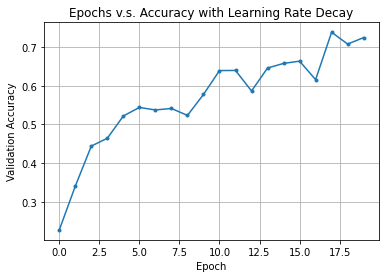

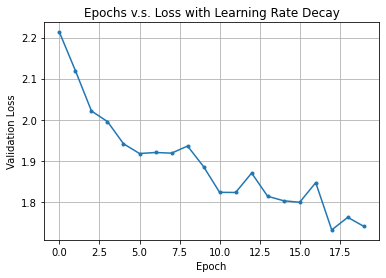

In [ ]:
plt.plot(np.arange(0, 20), np.asarray(epoch_acc_decay)[:, 1], marker='.')
plt.grid(True)
plt.title("Epochs v.s. Accuracy with Learning Rate Decay")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

plt.plot(np.arange(0, 20), np.asarray(epoch_acc_decay)[:, 0], marker='.')
plt.grid(True)
plt.title("Epochs v.s. Loss with Learning Rate Decay")
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()